In [17]:
# Import methods

%run Methods.ipynb

In [18]:
#STD_02 Second sample for Xinhua after breaking 1st at 5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_02'
setup_files(path)
area = np.pi
thickness = 90
sample = 'STD_02'
results = cc(path, area, thickness, sample)

In [19]:
### PLOT STD_02

# cv_plot(results[0], color_map, 100)
# cc_plot(results, color_map, 100)

In [20]:
# STD_02_2 New sample after blowing up to 5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_02_2'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 1C'
std02_1C = cc(path, area, thickness, sample)
# std02_1C[0]

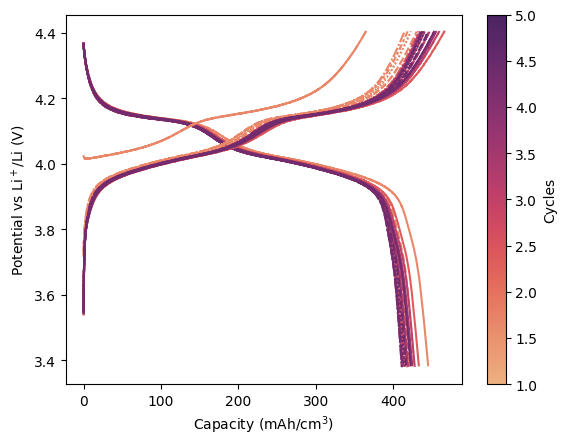

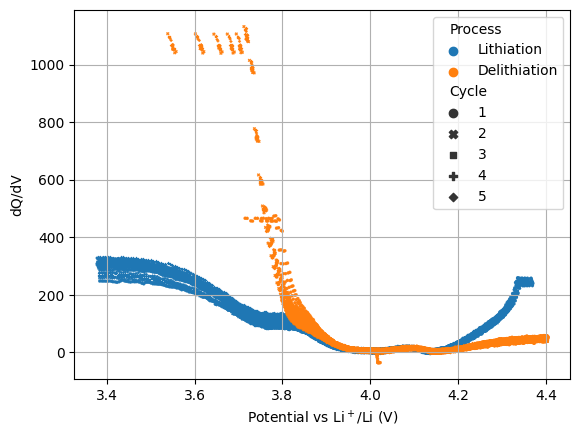

In [35]:
###PLOT STD_02_2
# cv_plot(std02_1C[0], color_map, 100)
cc_plot(std02_1C, color_map, 100)
dq_dv_plot(std02_1C, color_map, 100)
# plt.ylim(-100, 400)

In [22]:
# STD_02_2C
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD02_2C'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 2C'
std02_2c = cc(path, area, thickness, sample)

In [23]:
##### PLOT STD02 2C
# cv_plot(std02_2c[0], color_map, 100)
# cc_plot(std02_2c, color_map, 100)
# dq_dv_plot(std02_2c, color_map, 100)
# plt.ylim(-10, 250)

In [24]:
# STD_02_5C
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_02_5C'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 5C'
std02_5c = cc(path, area, thickness, sample)

In [25]:
#### STD_02_5C Plot
# cv_plot(std02_5c[0], color_map, 100)
# cc_plot(std02_5c, color_map, 100)
# dq_dv_plot(std02_5c, color_map, 100)
# plt.ylim(-10, 100)

In [26]:
# New LMO cv low potentials 1.5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_CV'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO lp 1.5V'
std02_lp = cc(path, area, thickness, sample)

In [27]:
# LMO lp PLOT
# cv_plot(std02_lp[0], color_map, 100)

In [28]:
# New LMO cycling scanning at low potentials
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_CV_afterlowpot'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO std'
std02_lowp = cc(path, area, thickness, sample)

In [29]:
# # LMO cycling afterlow pot PLOTS
# color_map = 'flare'
# cv_plot(std02_lowp[0], color_map, 100)

# cc_plot(std02_lowp, color_map, 100)
# plt.grid()
# dq_dv_plot(std02_lowp, color_map, 100)
# plt.ylim(-10, 200)

In [30]:
#### LMO cycled 1V

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_to1V'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO cycled 1V'
std02_1v = cc(path, area, thickness, sample)

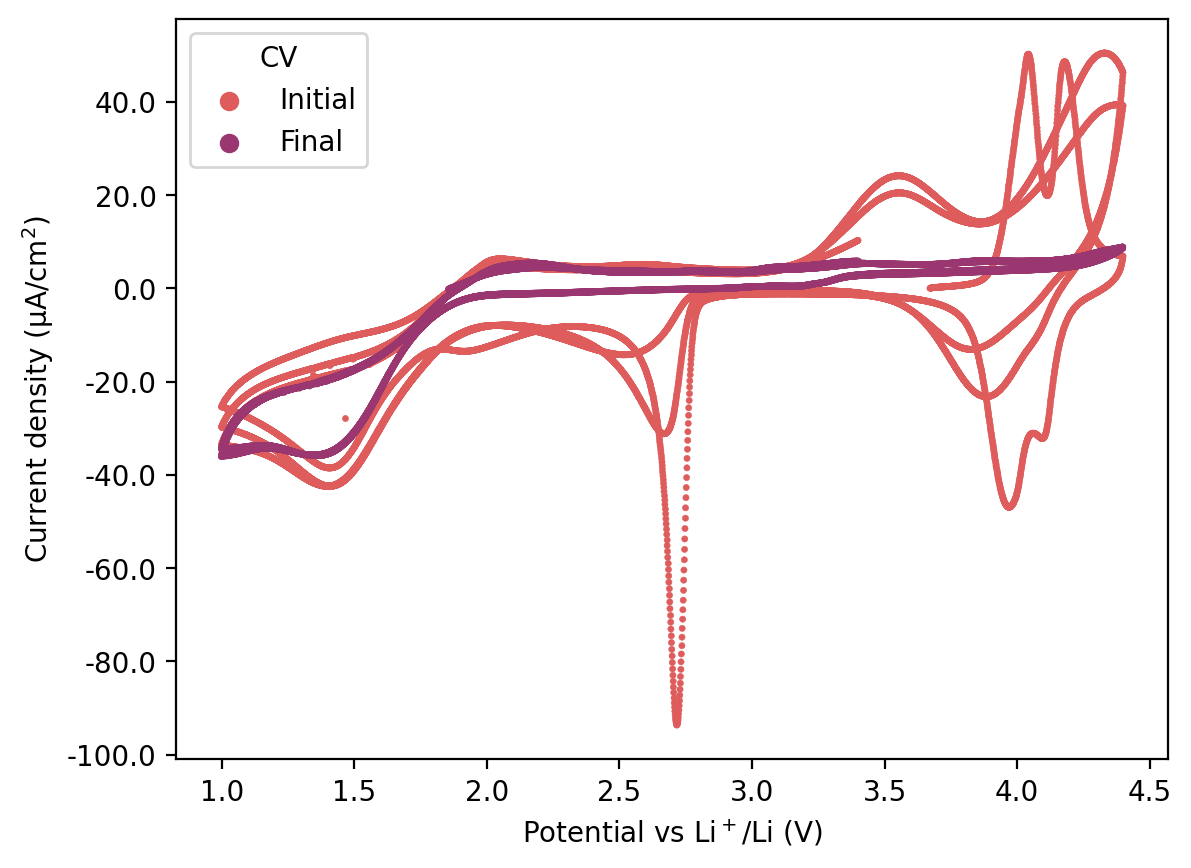

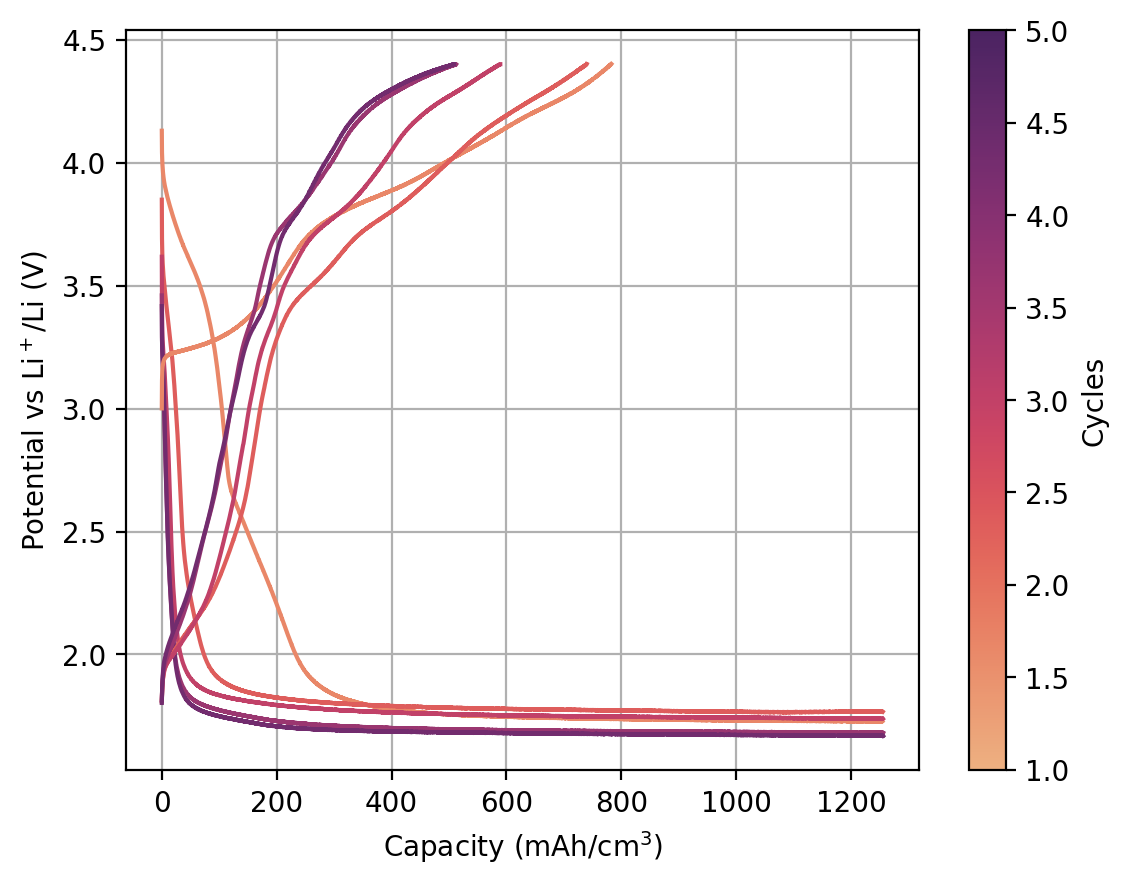

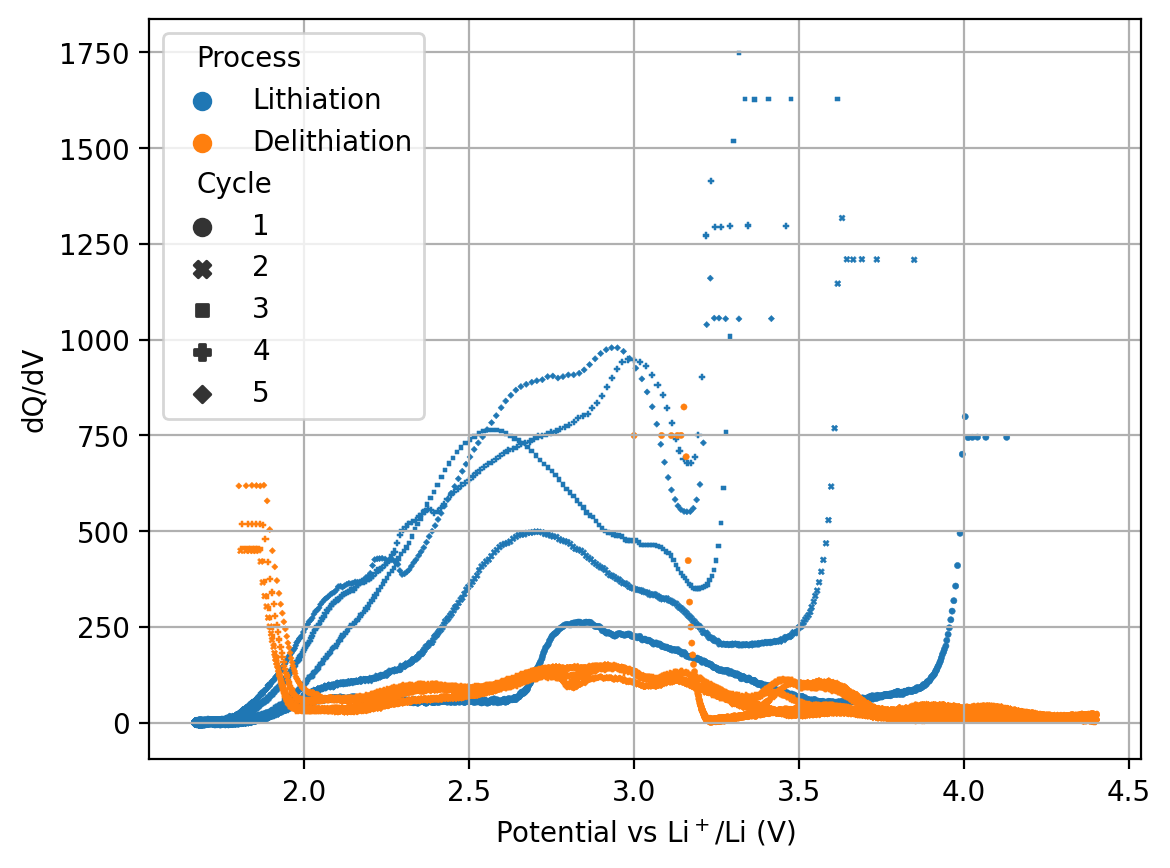

In [31]:
### PLOTS LMO cycled 1V 
color_map = 'flare'
dpi = 200
cv_plot(std02_1v[0], color_map, dpi)

cc_plot(std02_1v, color_map, dpi)
plt.grid()
dq_dv_plot(std02_1v, color_map, dpi)
# plt.ylim(-10, 200)

In [32]:
# ###### Compile 1C, 2C and 5C
# results = [std02_1C, std02_2c, std02_5c]
# results_df = pd.DataFrame()
# for i in results:
#     results_df = pd.concat([results_df, i[1], i[2]], ignore_index = True)
# fig, ax = plt.subplots(dpi = 100)

# sns.scatterplot(data = results_df, x = 'Capacity (mAh/cm$^3$)', y = 'WE(1).Potential (V)', hue = 'Sample', edgecolor = None, s = 2)


# #Remove data below 3.4 V
